In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [2]:
file_path = '/content/retail_price.csv'
data = pd.read_csv(file_path)

In [3]:
data = data.dropna()

In [4]:
print("Dataset Information:")
print(data.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday       

In [5]:
data.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [6]:
missing_values = data.isnull().sum()
duplicates = data.duplicated().sum()
print("\nMissing values per column:")
print(missing_values)
print(f"\nNumber of duplicate rows: {duplicates}")



Missing values per column:
product_id                    0
product_category_name         0
month_year                    0
qty                           0
total_price                   0
freight_price                 0
unit_price                    0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_score                 0
customers                     0
weekday                       0
weekend                       0
holiday                       0
month                         0
year                          0
s                             0
volume                        0
comp_1                        0
ps1                           0
fp1                           0
comp_2                        0
ps2                           0
fp2                           0
comp_3                        0
ps3                           0
fp3                           0
lag_price                     0
dtype: int64

In [7]:
data['month_year'] = pd.to_datetime(data['month_year'], format='%d-%m-%Y')


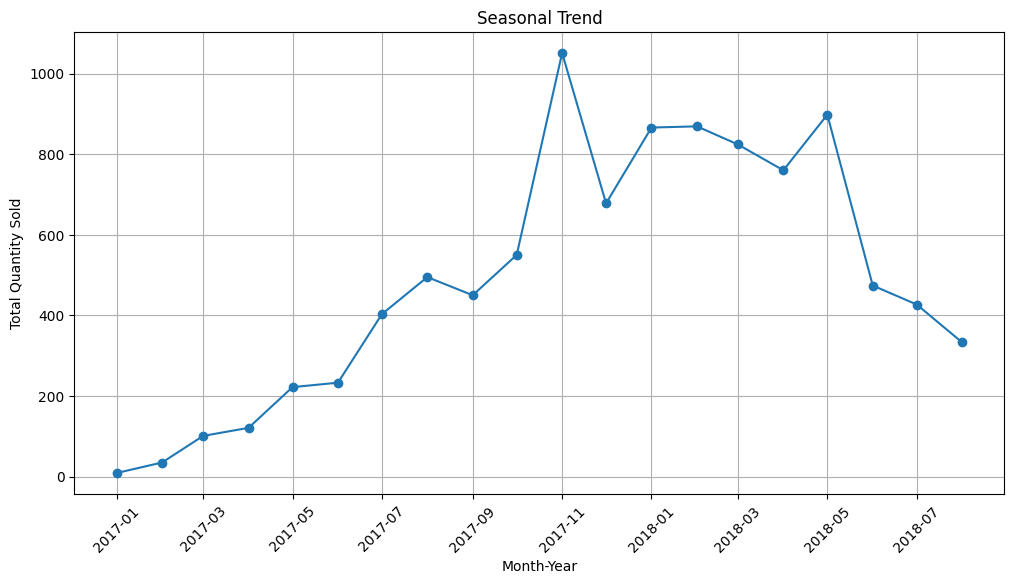

In [8]:
monthly_sales = data.groupby(data['month_year'].dt.to_period('M'))['qty'].sum()
monthly_sales.index = monthly_sales.index.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
plt.title("Seasonal Trend")
plt.xlabel("Month-Year")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

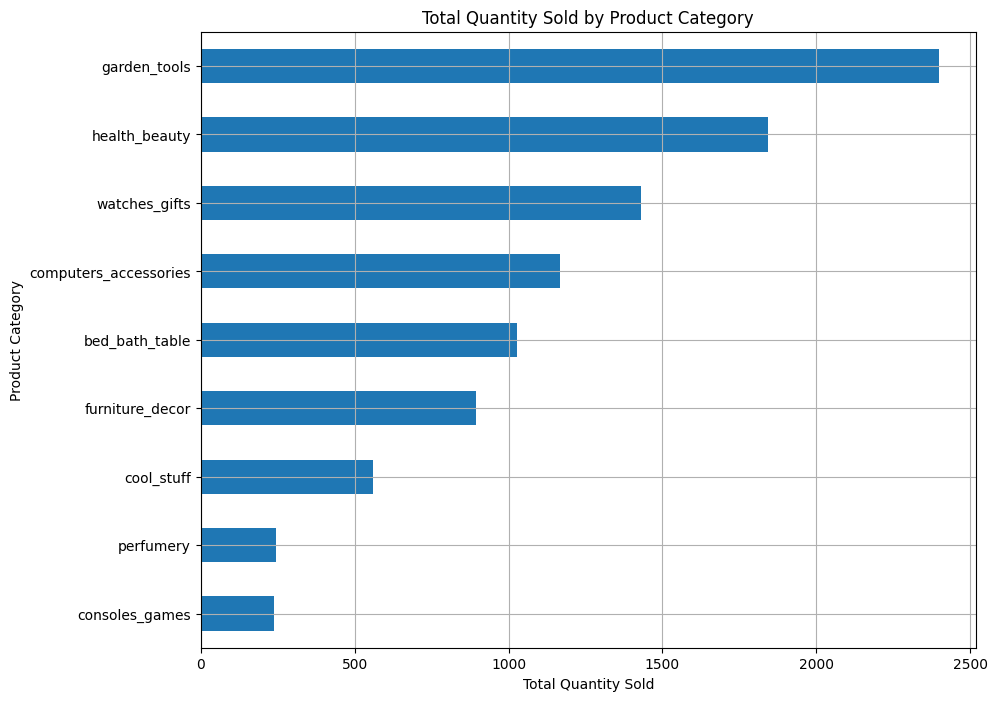

In [9]:
category_sales = data.groupby('product_category_name')['qty'].sum().sort_values()

plt.figure(figsize=(10, 8))
category_sales.plot(kind='barh')
plt.title("Total Quantity Sold by Product Category")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Category")
plt.grid(True)
plt.show()

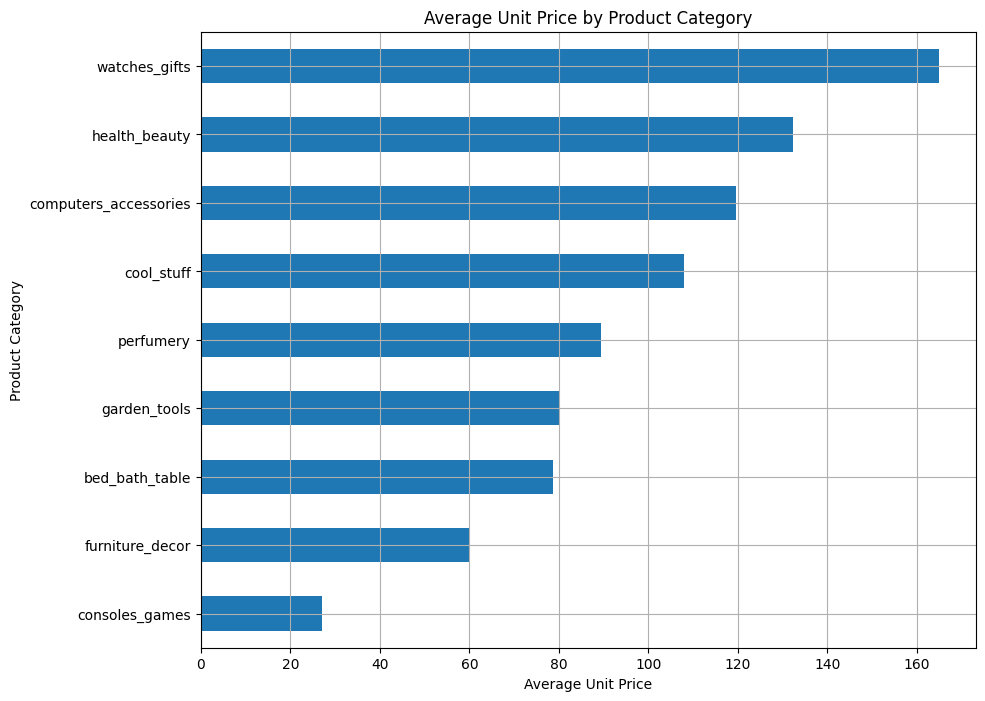

In [10]:
category_avg_price = data.groupby('product_category_name')['unit_price'].mean().sort_values()

plt.figure(figsize=(10, 8))
category_avg_price.plot(kind='barh')
plt.title("Average Unit Price by Product Category")
plt.xlabel("Average Unit Price")
plt.ylabel("Product Category")
plt.grid(True)
plt.show()


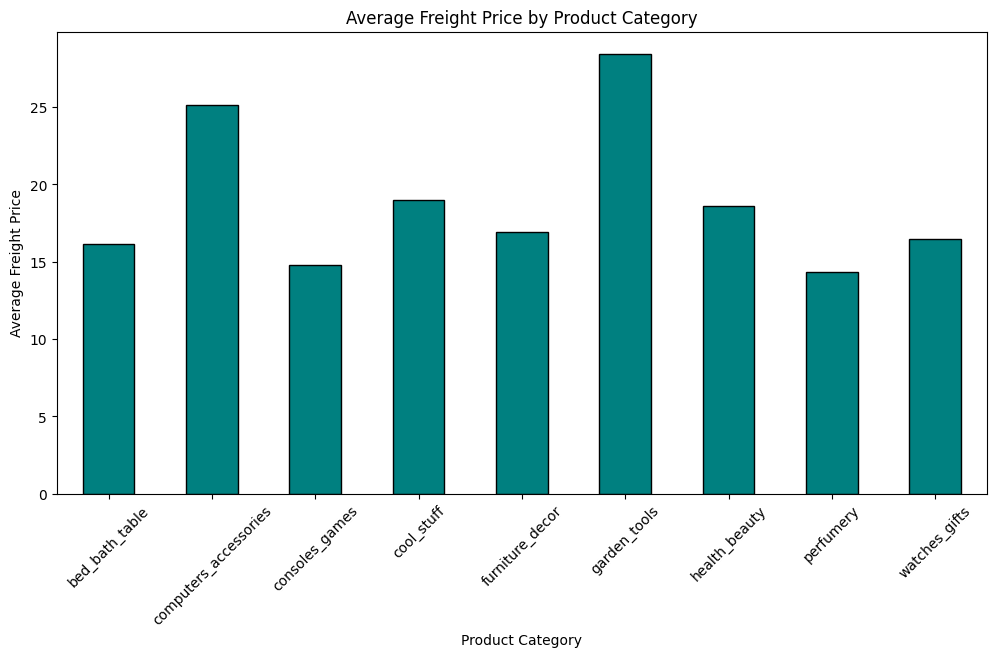

In [11]:
plt.figure(figsize=(12, 6))
data.groupby('product_category_name')['freight_price'].mean().plot(kind='bar', color='teal', edgecolor='black')
plt.title('Average Freight Price by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Freight Price')
plt.xticks(rotation=45)
plt.show()

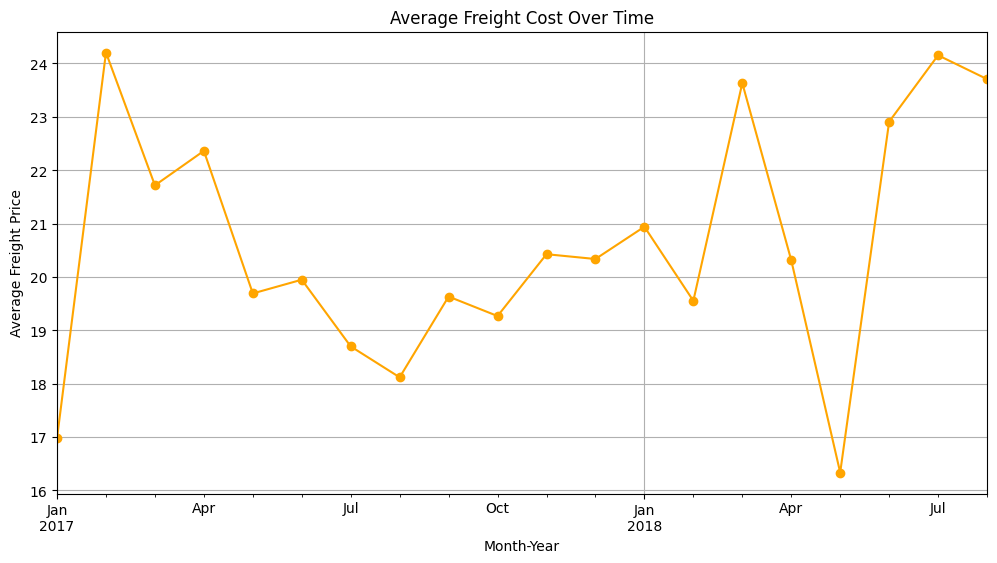

In [12]:
# Calculate the average freight price per month
monthly_freight_cost = data.groupby(data['month_year'].dt.to_period("M"))['freight_price'].mean()

# Plotting the average freight price per month
plt.figure(figsize=(12, 6))
monthly_freight_cost.plot(kind='line', marker='o', color='orange')
plt.title("Average Freight Cost Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Average Freight Price")
plt.grid(True)
plt.show()

In [14]:
X = data.drop(columns=['qty', 'product_id', 'month_year', 'product_category_name'])
y = data['qty']

In [15]:
ordering_cost = 50          # Cost per order (S)
holding_cost = 5            # Holding cost per unit per year (H)
lead_time_days = 7          # Lead time in days (L)
z_score = 1.65

In [16]:
annual_demand = data['qty'].sum()

In [17]:
eoq = np.sqrt((2 * annual_demand * ordering_cost) / holding_cost)


In [18]:
demand_per_day = annual_demand / 365
reorder_point = demand_per_day * lead_time_days

In [19]:
# Safety Stock Calculation
# Assuming standard deviation of daily demand as the standard deviation of 'qty' divided by sqrt(365)
daily_demand_std = data['qty'].std() / np.sqrt(365)
safety_stock = z_score * daily_demand_std * np.sqrt(lead_time_days)

In [20]:
# Total Inventory Cost Calculation
total_cost = (annual_demand / eoq) * ordering_cost + (eoq / 2) * holding_cost

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
y_pred = model.predict(X_test)

In [24]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, mse, r2

(1.4727941176470587, 19.775504411764704, 0.9270529089371261)

In [25]:
# Display results
print("Optimal Order Quantity (EOQ):", round(eoq, 2))
print("Reorder Point:", round(reorder_point, 2))
print("Safety Stock:", round(safety_stock, 2))
print("Total Inventory Cost: $",round(total_cost, 2))

Optimal Order Quantity (EOQ): 442.7
Reorder Point: 187.93
Safety Stock: 3.53
Total Inventory Cost: $ 2213.48


In [26]:
print("\nModel Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Model Performance Metrics:
Mean Absolute Error (MAE): 1.4727941176470587
Mean Squared Error (MSE): 19.775504411764704
R-squared (R2): 0.9270529089371261
